# A Simple Neural Net with PyTorch

## Neural Net Definition

In [1]:
# Basic Imports
import torch
import torch.nn as nn

In [2]:
# Method 1
model = nn.Sequential(
    nn.Linear(32 * 32 * 3, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

In [3]:
# Method 2
class SimpleNN(nn.Module):
  def __init__(self):
    super(SimpleNN, self).__init__()
    self.fc1 = nn.Linear(32 * 32 * 3, 128)  # First hidden layer with 128 neurons
    self.fc2 = nn.Linear(128, 64)  # Second hidden layer with 64 neurons
    self.fc3 = nn.Linear(64, 10)  # Output layer with 10 neurons (10 classes in CIFAR-10 dataset)

  def forward(self, x):
    x = x.view(-1, 32 * 32 * 3)  # Flatten the input image to a 1D tensor (-1 used as a placeholder to infer the batch size automatically)
    x = torch.relu(self.fc1(x))  # Apply ReLU Actviation to the first hidden layer
    x = torch.relu(self.fc2(x))  # Apply ReLU Activation to the second hidden layer
    x = self.fc3(x)  # Output layer (no activation function)
    return x


## Load and preprocess CIFAR-10 dataset

In [4]:
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [5]:
# Define a series of image transformations
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        # Normalize pixel values in 3 channels (convert from [0, 255] to [0, 1] to [-1, 1])
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Dataloaders that handle batching, shuffling & parallel data loading for train & test datasets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:02<00:00, 65626607.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define Model, Loss function and Optimizer

In [6]:
# Create an instance of SimpleNN class
model = SimpleNN()

# Cross Entropy Loss for Multi-Class Classification
criterion = nn.CrossEntropyLoss()

# Mini-Batch Stochastic Gradient Descent Optimizer
# model.parameters() -> parameters to be updated
# lr -> learning rate that controls stepsize of weight updates
# momentum -> to accelerate convergence
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Train SimpleNN model for "n" epochs

In [7]:
n_epochs = 5
for epoch in range(n_epochs):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    inputs, labels = data  # data is a list of [inputs, labels]

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward Pass
    outputs = model(inputs)

    # Loss Calculation
    loss = criterion(outputs, labels)

    # Backpropagation (find gradients)
    loss.backward()

    # Update parameters
    optimizer.step()

    # Extract numerical value of loss
    loss_value = loss.item()

    # Print statistics
    running_loss += loss_value

    if (i + 1) % 2000 == 0:  # Print every 2000 mini-batches
      print(f"Epoch {epoch + 1} Mini-Batch {i + 1:5d} -> Loss = {running_loss / 2000:.3f}")
      running_loss = 0.0

print(f"Finished training for {n_epochs} epochs")

Epoch 1 Mini-Batch  2000 -> Loss = 1.929
Epoch 1 Mini-Batch  4000 -> Loss = 1.719
Epoch 1 Mini-Batch  6000 -> Loss = 1.662
Epoch 1 Mini-Batch  8000 -> Loss = 1.620
Epoch 1 Mini-Batch 10000 -> Loss = 1.597
Epoch 1 Mini-Batch 12000 -> Loss = 1.565
Epoch 2 Mini-Batch  2000 -> Loss = 1.494
Epoch 2 Mini-Batch  4000 -> Loss = 1.481
Epoch 2 Mini-Batch  6000 -> Loss = 1.480
Epoch 2 Mini-Batch  8000 -> Loss = 1.494
Epoch 2 Mini-Batch 10000 -> Loss = 1.474
Epoch 2 Mini-Batch 12000 -> Loss = 1.432
Epoch 3 Mini-Batch  2000 -> Loss = 1.383
Epoch 3 Mini-Batch  4000 -> Loss = 1.387
Epoch 3 Mini-Batch  6000 -> Loss = 1.378
Epoch 3 Mini-Batch  8000 -> Loss = 1.387
Epoch 3 Mini-Batch 10000 -> Loss = 1.385
Epoch 3 Mini-Batch 12000 -> Loss = 1.378
Epoch 4 Mini-Batch  2000 -> Loss = 1.287
Epoch 4 Mini-Batch  4000 -> Loss = 1.334
Epoch 4 Mini-Batch  6000 -> Loss = 1.299
Epoch 4 Mini-Batch  8000 -> Loss = 1.321
Epoch 4 Mini-Batch 10000 -> Loss = 1.341
Epoch 4 Mini-Batch 12000 -> Loss = 1.317
Epoch 5 Mini-Bat

## Metrics

In [8]:
import matplotlib.pyplot as plt

### Accuracy

In [9]:
# Set SimpleNN model to evaluation mode

# Dropout layers drops out (sets to zero) a fraction of the neurons in a layer during each forward pass
# Batch Normalization layers normalize the activations of each layer so that
# they have a mean of zero and a standard deviation of one

# In evaluation mode
# 1- Dropout layers are turned off
# 2- Batch Normalization layers do not compute new batch statistics (mean & standard deviation),
#    instead they use learned statistics from training
model.eval()

# Initialize variables to keep track of correct predictions and total test samples
correct, total = 0, 0

# List to store accuracy values for each batch
accuracy_values = []

# Disable gradient computation for evaluation
with torch.no_grad():
  for batch_num, data in enumerate(testloader, 1):
    images, labels = data

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    n_total_labels = labels.size(0)
    n_correct_labels = (predicted == labels).sum().item()

    total += n_total_labels
    correct += n_correct_labels

    # Calculate accuracy for the current batch
    batch_accuracy = n_correct_labels / n_total_labels

    # Print accuracy every 100 batches
    if batch_num % 100 == 0:
        accuracy = 100 * correct / total
        accuracy_values.append(accuracy)
        print(f'Batch {batch_num}: Accuracy = {accuracy:.2f}%')
    accuracy_values.append(batch_accuracy)

# Calculate the overall accuracy
accuracy = 100 * correct / total
print(f"Accuracy on the test images: {accuracy:.2f}%")


Batch 100: Accuracy = 54.75%
Batch 200: Accuracy = 52.38%
Batch 300: Accuracy = 54.08%
Batch 400: Accuracy = 53.25%
Batch 500: Accuracy = 52.25%
Batch 600: Accuracy = 52.42%
Batch 700: Accuracy = 52.14%
Batch 800: Accuracy = 52.25%
Batch 900: Accuracy = 52.47%
Batch 1000: Accuracy = 52.65%
Batch 1100: Accuracy = 53.05%
Batch 1200: Accuracy = 52.98%
Batch 1300: Accuracy = 52.60%
Batch 1400: Accuracy = 52.16%
Batch 1500: Accuracy = 51.87%
Batch 1600: Accuracy = 51.77%
Batch 1700: Accuracy = 51.72%
Batch 1800: Accuracy = 51.54%
Batch 1900: Accuracy = 51.50%
Batch 2000: Accuracy = 51.42%
Batch 2100: Accuracy = 51.08%
Batch 2200: Accuracy = 51.06%
Batch 2300: Accuracy = 51.15%
Batch 2400: Accuracy = 51.11%
Batch 2500: Accuracy = 50.97%
Accuracy on the test images: 50.97%


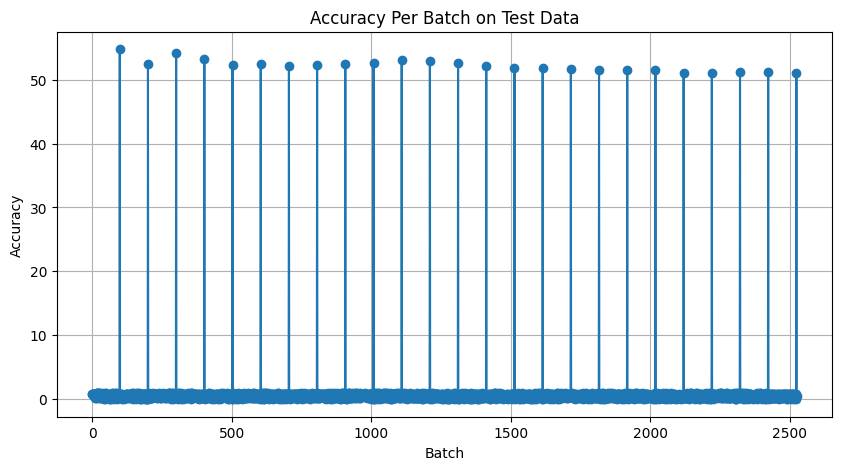

In [10]:
# Plot the accuracy values for every 100 batches
plt.figure(figsize=(10, 5))
plt.plot(accuracy_values, marker='o', linestyle='-')
plt.title('Accuracy Per Batch on Test Data')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
import matplotlib.pyplot as plt

In [12]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Iterate through the test dataset to collect true labels and predicted probabilities
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        true_labels.extend(labels.numpy())
        predicted_probs.extend(probs.numpy())

# Convert the lists to numpy arrays
true_labels = np.array(true_labels)
predicted_probs = np.array(predicted_probs)

In [13]:
# Calculate and print Accuracy
predicted_labels = np.argmax(predicted_probs, axis=1)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 50.97%


In [14]:
# Calculate and print Precision, Recall, and F1 Score
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

Precision: 0.52
Recall: 0.51
F1 Score: 0.50


In [15]:
# Calculate and print True Negative Rate (Specificity) and False Positive Rate
cm = confusion_matrix(true_labels, predicted_labels)
tnr = cm[0, 0] / (cm[0, 0] + cm[0, 1])
fpr = 1 - tnr
print(f'True Negative Rate (Specificity): {tnr:.2f}')
print(f'False Positive Rate: {fpr:.2f}')

True Negative Rate (Specificity): 0.90
False Positive Rate: 0.10


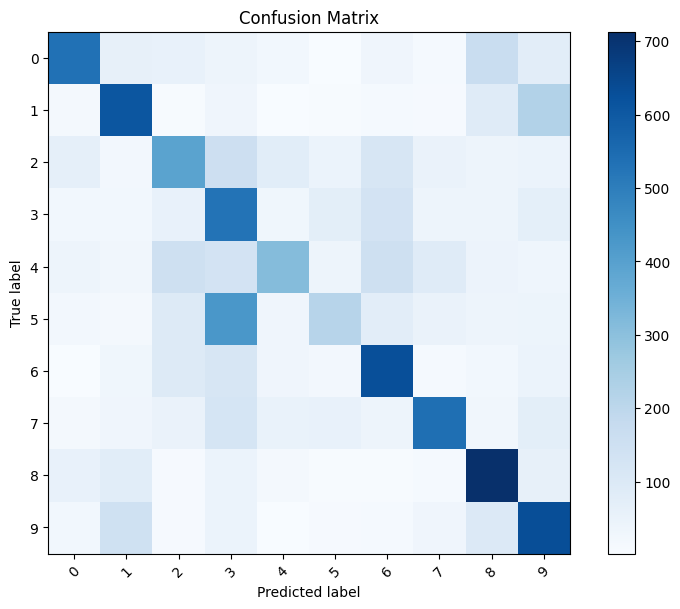

In [16]:
# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
target_names = [str(i) for i in range(10)]  # CIFAR-10 class names
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [17]:
# Calculate class-wise precision, recall, and F1-score
class_report = classification_report(true_labels, predicted_labels, target_names=target_names)
print(class_report)

              precision    recall  f1-score   support

           0       0.67      0.53      0.59      1000
           1       0.59      0.61      0.60      1000
           2       0.43      0.39      0.41      1000
           3       0.32      0.53      0.40      1000
           4       0.54      0.31      0.40      1000
           5       0.45      0.21      0.29      1000
           6       0.53      0.63      0.57      1000
           7       0.65      0.54      0.59      1000
           8       0.56      0.71      0.63      1000
           9       0.49      0.63      0.55      1000

    accuracy                           0.51     10000
   macro avg       0.52      0.51      0.50     10000
weighted avg       0.52      0.51      0.50     10000



In [18]:
# Accuracy per Class
class_accuracy = []
for class_idx in range(len(target_names)):
    correct = np.sum((true_labels == class_idx) & (predicted_labels == class_idx))
    total = np.sum(true_labels == class_idx)
    class_accuracy.append(correct / total)

print(f"class_accuracy = \n{class_accuracy}")

class_accuracy = 
[0.534, 0.608, 0.393, 0.527, 0.313, 0.211, 0.629, 0.539, 0.713, 0.63]


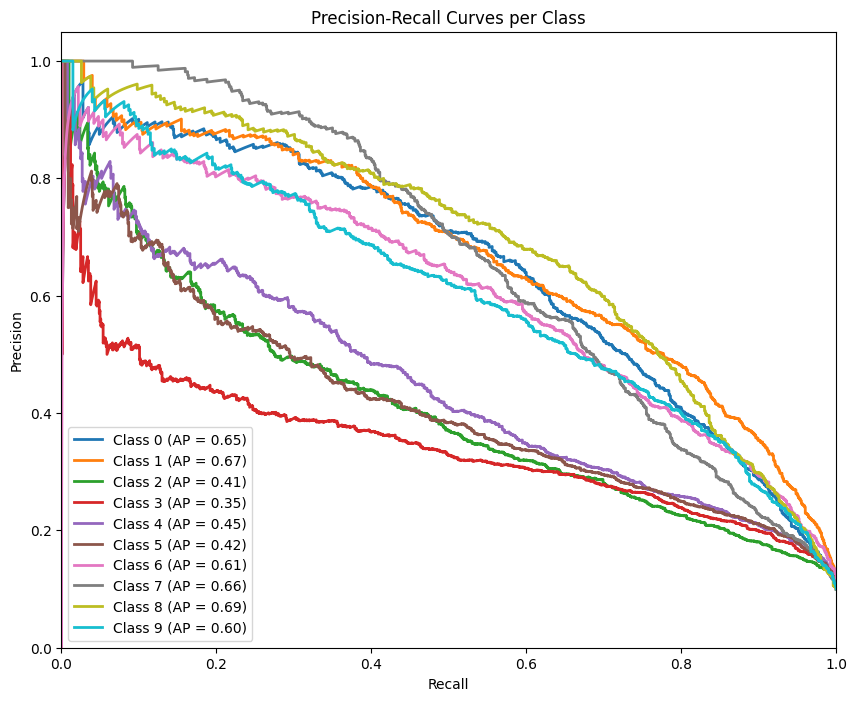

In [19]:
# Precision-Recall Curves per Class
precision_class = dict()
recall_class = dict()
avg_precision = dict()

for class_idx in range(len(target_names)):
    precision_class[class_idx], recall_class[class_idx], _ = \
        precision_recall_curve(true_labels == class_idx, predicted_probs[:, class_idx])
    avg_precision[class_idx] = auc(recall_class[class_idx], precision_class[class_idx])

# Plot PR curves for each class
plt.figure(figsize=(10, 8))
for class_idx in range(len(target_names)):
    plt.plot(recall_class[class_idx], precision_class[class_idx], lw=2,
             label=f'Class {class_idx} (AP = {avg_precision[class_idx]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves per Class')
plt.legend(loc="lower left")
plt.show()

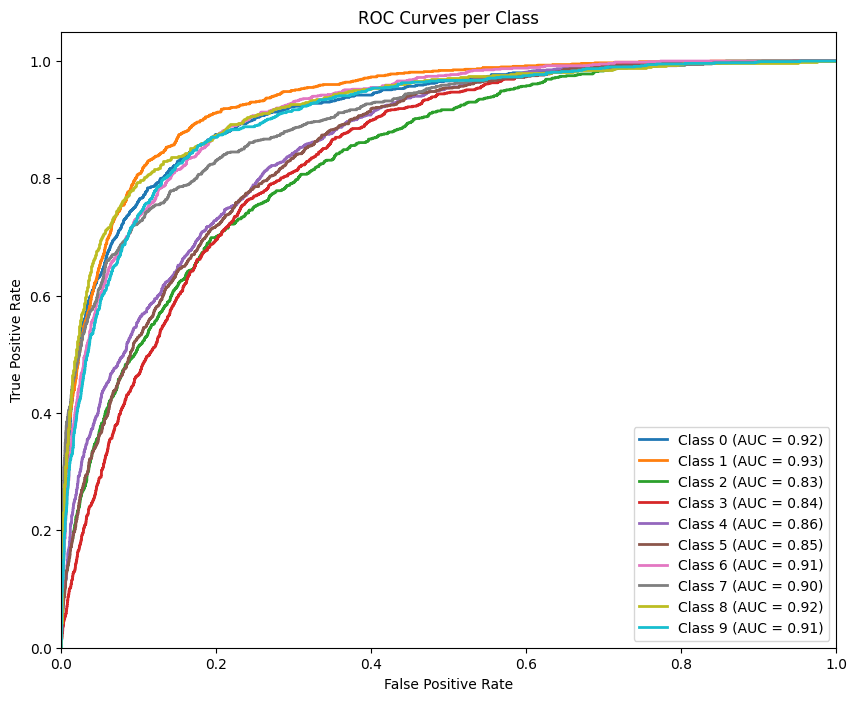

In [20]:
# Receiver Operating Characteristic (ROC) Curves per Class
fpr = dict()
tpr = dict()
roc_auc = dict()

for class_idx in range(len(target_names)):
    fpr[class_idx], tpr[class_idx], _ = roc_curve(true_labels == class_idx, predicted_probs[:, class_idx])
    roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for class_idx in range(len(target_names)):
    plt.plot(fpr[class_idx], tpr[class_idx], lw=2, label=f'Class {class_idx} (AUC = {roc_auc[class_idx]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend(loc="lower right")
plt.show()

## Inference on Test Image

In [21]:
from PIL import Image

test_image_path = "/content/deer.jpg"

# Load and preprocess the test image
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),  # Resize to match CIFAR-10 image size
        transforms.ToTensor(),  # Convert Image to PyTorch tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Same as applied to CIFAR-10 dataset
    ]
)
original_image = Image.open(test_image_path)
image = transform(original_image).unsqueeze(0)  # Add a batch dimension (batch size of 1)

In [26]:
# Perform inference

# Set the model to evaluation mode
model.eval()

with torch.no_grad():
  output = model(image)
  print(f"output = \n{output}")

# Convert output to probabilities using softmax
probabilities = torch.softmax(output, dim=1)
print(f"probabilities = \n{probabilities}")

# Get predicted class index
predicted_class_index = torch.argmax(probabilities, dim=1).item()
print(f"predicted_class_index = {predicted_class_index}")

output = 
tensor([[-0.6463, -2.3515,  2.9382,  0.4419,  5.2978,  0.5327, -2.8916,  3.5651,
         -3.9884, -3.9012]])
probabilities = 
tensor([[2.0303e-03, 3.6898e-04, 7.3161e-02, 6.0277e-03, 7.7451e-01, 6.6002e-03,
         2.1499e-04, 1.3694e-01, 7.1792e-05, 7.8338e-05]])
predicted_class_index = 4


In [27]:
# Print results
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
predicted_class_name = class_names[predicted_class_index]
print(f"Predicted Class = {predicted_class_name}")

Predicted Class = deer


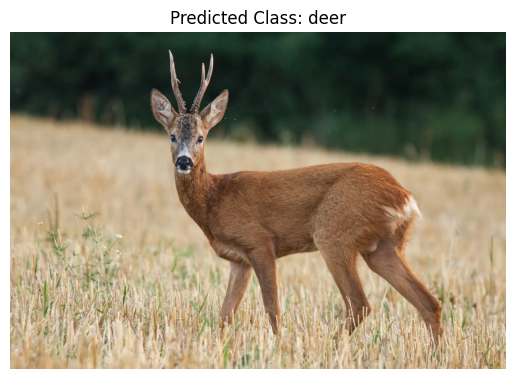

In [28]:
# Plot the test image
plt.imshow(original_image)
plt.title(f'Predicted Class: {predicted_class_name}')
plt.axis('off')  # Turn off axis labels
plt.show()